#Loading and transforming data

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import isodate
import numpy as np
import shap

In [16]:
df = pd.read_csv('Data/results/video_data_final.csv')
df = pd.read_csv('video_data_final (128vids).csv')

df['log_views'] = np.log1p(df['views'])
df['log_view_deviation'] = df['log_views'] - df['log_views'].mean()

# Feature engineer
# Maybe normalize or log transform view_deviation
df['published_at'] = pd.to_datetime(df['published_at'])
df['hour'] = df['published_at'].dt.hour
df['day_of_week'] = df['published_at'].dt.dayofweek
#df['month'] = df['published_at'].dt.month
df['duration_minutes'] = df['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds() / 60)

Prepare data for modeling

In [17]:
# Define features and target
X = df.drop(columns=['log_views', 'views', 'log_view_deviation', 'video_id', 'video_title', 'published_at', 'video_url', 'playlist_id', 'channel_title', 'likes', 'comments', 'duration', 'playlist_name'])
# Drop variables with low importance
# X = X.drop(columns=['day_of_week', 'brightness', 'title is plain', 'mean_g'])
# Fight positive skew
y = df['log_view_deviation']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.columns.tolist())

['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral', 'pct_with_face', 'brightness', 'mean_r', 'mean_g', 'mean_b', 'blurriness', 'title is plain', 'title is emotionally touching', 'title is exaggerated', 'hour', 'day_of_week', 'duration_minutes']


Train models

Random Forest

RMSE: 0.4647924108747296
R²: -0.09511442908032053


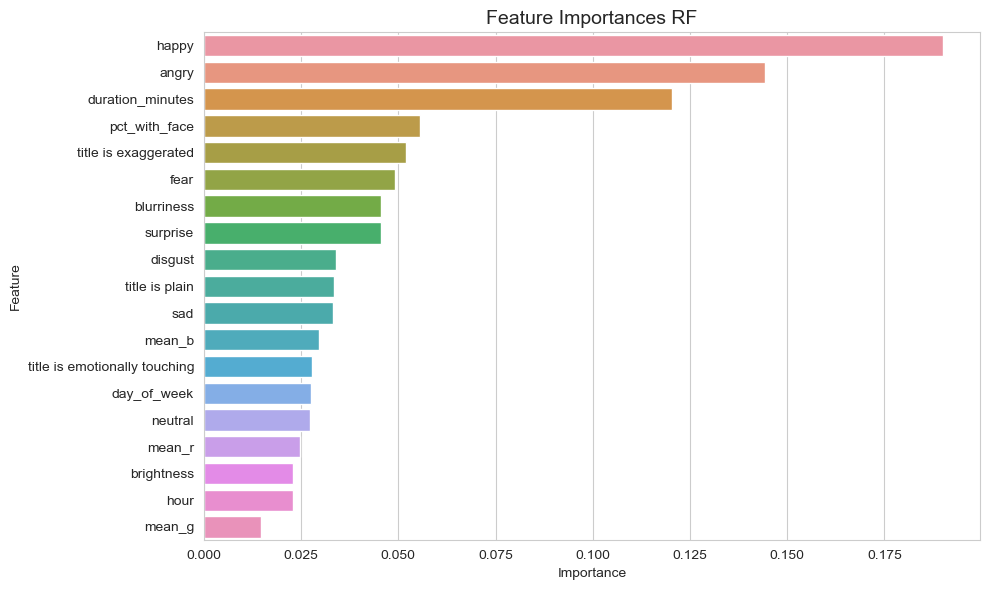

In [18]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('RMSE:', mean_squared_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))

importances = model.feature_importances_
features = X.columns
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.barplot(
    data=feat_imp_df,
    x='Importance',
    y='Feature')
plt.title('Feature Importances RF', fontsize=14)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


XGBoost

RMSE: 0.48299708300147315
R²: -0.13800712409045146


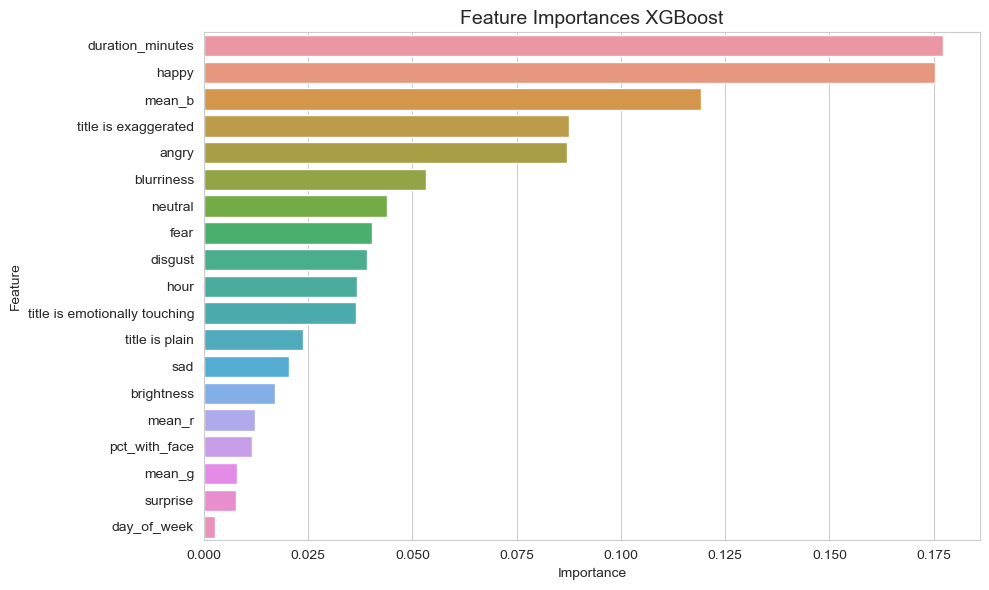

In [19]:
modelXG = xgb.XGBRegressor(random_state=42, verbosity=0)
modelXG.fit(X_train, y_train)

y_pred = modelXG.predict(X_test)

print('RMSE:', mean_squared_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))

importances = modelXG.feature_importances_
features = X.columns
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.barplot(
    data=feat_imp_df,
    x='Importance',
    y='Feature')
plt.title('Feature Importances XGBoost', fontsize=14)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Calculate Feature importance with SHapley Additive exPlanations

Random Forest:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


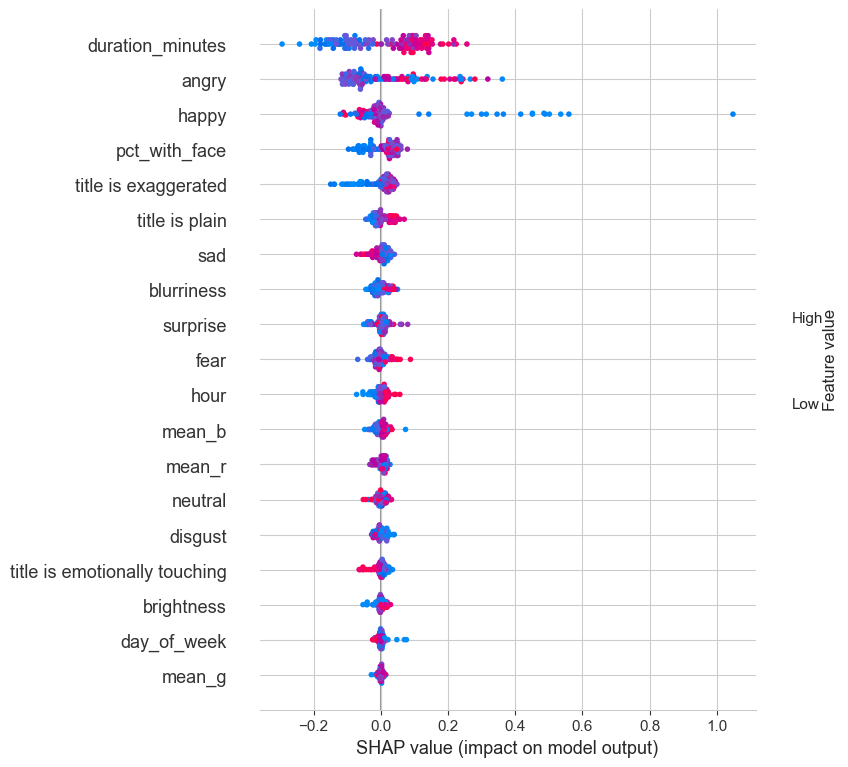

In [25]:
explainer = shap.TreeExplainer(model, X)
shap_values = explainer.shap_values(X, check_additivity=False)
print("Random Forest:")
shap.summary_plot(shap_values, X)


XGBoost:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


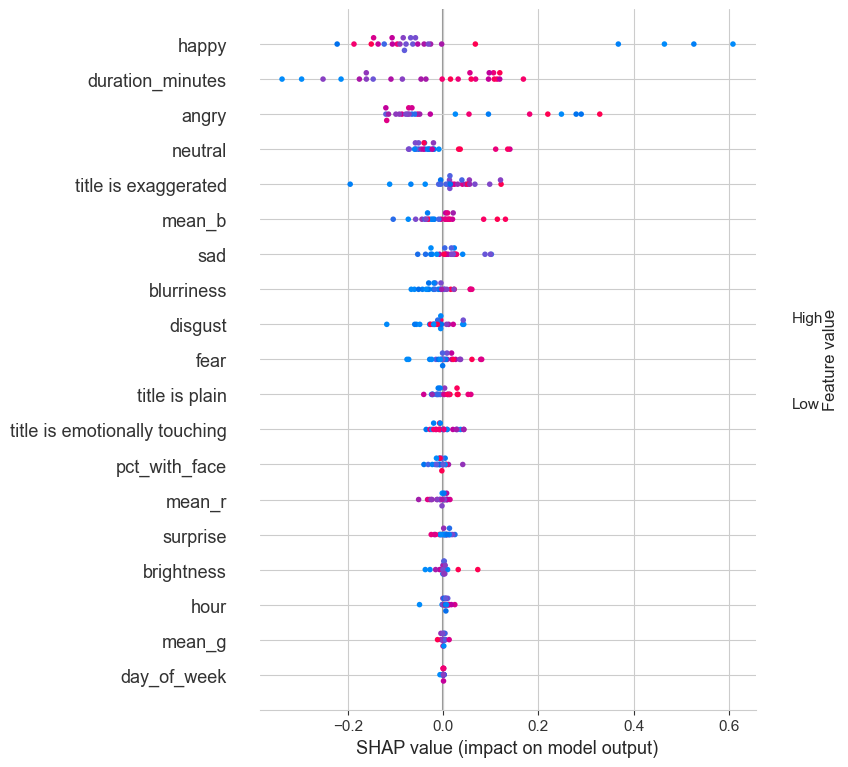

In [26]:
masker = shap.maskers.Independent(X_train)
explainer = shap.Explainer(modelXG.predict, masker)
shap_values = explainer(X_test)
print("XGBoost:")
shap.summary_plot(shap_values, X_test)
